# 0. Preparation

## Mount google drive
- Make sure that available access is the user's own drive(no access across files in shared folder)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
if 'google.colab' in str(get_ipython()):
  IN_COLLAB = True
else:
  IN_COLLAB = False

#TODO: CHANGE THIS BASED ON YOUR OWN LOCAL SETTINGS
MY_HOME_ABS_PATH =  "/content/drive/MyDrive/TFT_baseline"

In [4]:
# # Clone Git to GDrive
# os.chdir('/content/drive/MyDrive/W210/')
# !git config --global user.name ruminakagawa
# !git config --global user.email "ruminakagawa@berkeley.edu"
# !git clone https://github.com/jcalz23/co2-flux-hourly-gpp-modeling.git

#### (pip install)

In [5]:
! pip install statsmodels --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


numba may potentially needed later

In [6]:
!pip install numba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
!pip install azure-storage-blob==12.14.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
!pip install xgboost
# !conda install -c conda-forge xgboost
# !conda install -c anaconda py-xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import Modules

In [9]:
# MY_HOME_ABS_PATH = "/root/co2-flux-hourly-gpp-modeling"
MY_HOME_ABS_PATH =  "/content/drive/MyDrive/TFT_baseline"

In [10]:
import os
import sys
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import seaborn as sns 

import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load locale custome modules
os.chdir(MY_HOME_ABS_PATH)
sys.path.append('./.cred')
sys.path.append('./code/src/tools')
sys.path.append('./code/src/tools/CloudIO')

from azure.storage.blob import BlobServiceClient
# from CloudIO.AzStorageClient import AzStorageClient
import AzStorageClient
from azure.storage.blob import BlobServiceClient
from data_pipeline_lib import *


pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
# pl.seed_everything(42)

# Load data from Azure blob

In [11]:
root_dir =  MY_HOME_ABS_PATH
tmp_dir =  root_dir + os.sep + 'tmp'
raw_data_dir = tmp_dir
data_dir = root_dir + os.sep + 'data'
cred_dir = root_dir + os.sep + 'cred'
az_cred_file = cred_dir + os.sep + 'azblobcred.json'

In [12]:
# AzStorageClient.listBlobs(container)
container = "baseline-data"
cred_file = az_cred_file
ext = "parquet"

# Container and file name
blob_name_train = "baseline-train-v-1-i-knn.parquet"
blob_name_val = "baseline-test-v-1-i-knn.parquet"

In [13]:
if os.path.exists(cred_file):
  connect_str = ""
  with open(cred_file, "rb") as f:
      data = json.load(f)
      connect_str = data['connectionstr']
      blob_svc_client = BlobServiceClient.from_connection_string(connect_str)
      tokens = connect_str.split(';')
      for t in tokens:
        if "AccountName=" in t:
          AccountName = t[len("AccountName="):]
        elif "AccountKey=" in t:
          AccountKey = t[len("AccountKey="):]

In [14]:
# Download train file
train_df = None
if not (os.path.exists(tmp_dir+blob_name_train)):
    azStorageClient = AzStorageClient(az_cred_file)
    file_stream = azStorageClient.downloadBlob2Stream(container, blob_name_train)
    train_df = pd.read_parquet(file_stream, engine='pyarrow')
    train_df.to_parquet(tmp_dir + blob_name_train)
else:
    train_df = pd.read_parquet(tmp_dir + blob_name_train)


# Load Test Data
test_df = None
if not (os.path.exists(tmp_dir+blob_name_val)):
    azStorageClient = AzStorageClient(az_cred_file)
    file_stream = azStorageClient.downloadBlob2Stream(container, blob_name_val)
    test_df = pd.read_parquet(file_stream, engine='pyarrow')
    test_df.to_parquet(tmp_dir + blob_name_val)
else:
    test_df = pd.read_parquet(tmp_dir + blob_name_val)

print(f"Train size: {train_df.shape}")
print(f"Test size: {test_df.shape}")

Train size: (631032, 49)
Test size: (234888, 49)


In [15]:
## Drop Cols and Prep Train/Test

target_variable = 'GPP_NT_VUT_REF'
drop_cols = ['gap_flag_hour', 'gap_flag_month', 'datetime', target_variable] + ['site_id'] # <----- site_id is temp drop, need to dummy encode in pipeline

# Extract the features and target variable from training data
X_train = train_df.drop(columns=drop_cols)
y_train = train_df[target_variable]

# Extract the features and target variable from test data
X_test = test_df.drop(columns=drop_cols)
y_test = test_df[target_variable]

print(f"Train size: {X_train.shape}")
print(f"Test size: {X_test.shape}")

Train size: (631032, 44)
Test size: (234888, 44)


## Fit Model: XGBoost

In [16]:
# Create an instance of XGBoost regressor

xgb_regressor = xgb.XGBRegressor(
                          n_estimators=100,
                          reg_lambda=1,
                          gamma=0,
                          max_depth=3
                      )

# Train the regressor on training data
start_time = time.time()
xgb_regressor.fit(X_train, y_train)
end_time = time.time()
fit_time = end_time - start_time
print("Time taken to fit the model: {:.2f} seconds".format(fit_time))

Time taken to fit the model: 127.99 seconds


## Evaluate Model

In [17]:
# Use the trained regressor to make predictions on test data
y_pred = xgb_regressor.predict(X_test)

# Calculate and print RMSE, MAE, and R-squared on the test set
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("RMSE: {:.2f}".format(rmse))
print("MAE: {:.2f}".format(mae))
print("R-squared: {:.2f}".format(r2))


RMSE: 3.60
MAE: 1.80
R-squared: 0.63


## Hyperparameter tuning using hyperopt

The available hyperopt optimization algorithms are -

`hp.choice(label, options)` — Returns one of the options, which should be a list or tuple.

`hp.randint(label, upper)` — Returns a random integer between the range [0, upper).

`hp.uniform(label, low, high)` — Returns a value uniformly between low and high.

`hp.quniform(label, low, high, q)` — Returns a value round(uniform(low, high) / q) * q, i.e it rounds the decimal values and returns an integer.

`hp.normal(label, mean, std)` — Returns a real value that’s normally-distributed with mean and standard deviation sigma.

In [18]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'n_estimators': 180,
        'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'seed': 0
    }

(Define X_val and y_val)

In [26]:
from sklearn.preprocessing import LabelEncoder
def objective(space):
    global X_train, y_train, X_val, y_val
    
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], 
                    max_depth = int(space['max_depth']), 
                    gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),
                    min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    rsme = mean_squared_error(y_test, y_pred, squared=False) # squared=False returns RMSE

    print ("SCORE(RMSE):", rmse)
    return {'loss': -rmse, 'status': STATUS_OK }

In [1]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 50,
                        trials = trials)

NameError: ignored

In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

### Tune best parameters

In [ ]:
best_xgb_regressor = xgb.XGBRegressor(
                          n_estimators=100,
                          reg_lambda=best_hyperparams['reg_alpha'],
                          gamma=best_hyperparams['gamma'],
                          max_depth=best_hyperparams['max_depth'],
                          colsample_bytree=best_hyperparams['colsample_bytree'],
                          min_child_weight=best_hyperparams['min_child_weight']
                      )
# Train the regressor on training data
start_time = time.time()
xgb_regressor.fit(X_train, y_train)
end_time = time.time()
fit_time = end_time - start_time
print("Time taken to fit the model: {:.2f} seconds".format(fit_time))

### Final prediction

In [ ]:
# Use the trained regressor to make predictions on test data
y_pred = best_xgb_regressor.predict(X_test)

# Calculate and print RMSE, MAE, and R-squared on the test set
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("RMSE: {:.2f}".format(rmse))
print("MAE: {:.2f}".format(mae))
print("R-squared: {:.2f}".format(r2))


## Feature importances(original model)

In [21]:
xgb_regressor.feature_importances_

array([0.0022066 , 0.        , 0.        , 0.00151997, 0.00164364,
       0.00459623, 0.00473062, 0.08375116, 0.00335762, 0.004031  ,
       0.00279181, 0.00277952, 0.00282711, 0.20622395, 0.0391751 ,
       0.00221495, 0.00327227, 0.0088791 , 0.00139389, 0.00390894,
       0.00575448, 0.00494682, 0.00745207, 0.00682221, 0.01273848,
       0.01765087, 0.        , 0.        , 0.00561094, 0.00160081,
       0.00443428, 0.00147925, 0.04458933, 0.00579405, 0.00259762,
       0.00531129, 0.        , 0.00105659, 0.        , 0.0030349 ,
       0.3233485 , 0.00890245, 0.00329352, 0.15427803], dtype=float32)

Text(0.5, 0, 'Xgboost Feature Importance')

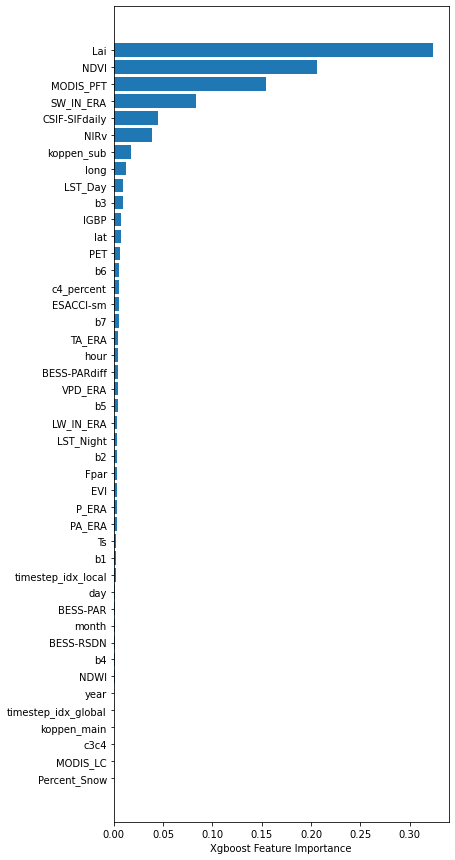

In [30]:
plt.figure(figsize=(6,15))
sorted_idx = xgb_regressor.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], xgb_regressor.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

In [45]:
sorted_idx

array([38, 36, 27, 26,  1,  2, 37, 18, 31,  3, 29,  4,  0, 15, 34, 11, 10,
       12, 39, 16, 42,  8, 19,  9, 30,  5,  6, 21, 35, 28, 20, 33, 23, 22,
       17, 41, 24, 25, 14, 32,  7, 43, 13, 40])

Text(0.5, 0, 'Xgboost Feature Importance')

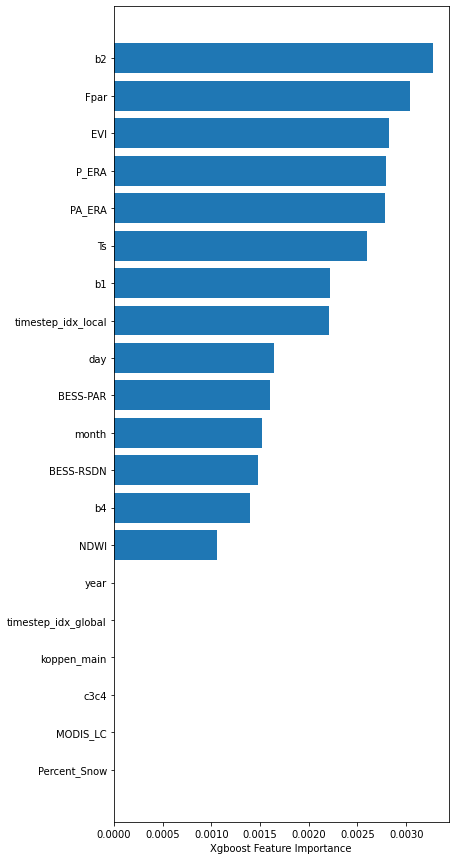

In [43]:
plt.figure(figsize=(6,15))
sorted_idx = xgb_regressor.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], xgb_regressor.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

In [42]:
sorted_idxs = xgb_regressor.feature_importances_.argsort()
for sorted_idx in sorted_idxs:
  print(f'{X_train.columns[sorted_idx]}: {round(xgb_regressor.feature_importances_[sorted_idx],4)}')

Percent_Snow: 0.0
MODIS_LC: 0.0
c3c4: 0.0
koppen_main: 0.0
timestep_idx_global: 0.0
year: 0.0
NDWI: 0.0010999999940395355
b4: 0.00139999995008111
BESS-RSDN: 0.001500000013038516
month: 0.001500000013038516
BESS-PAR: 0.0015999999595806003
day: 0.0015999999595806003
timestep_idx_local: 0.002199999988079071
b1: 0.002199999988079071
Ts: 0.0026000000070780516
PA_ERA: 0.00279999990016222
P_ERA: 0.00279999990016222
EVI: 0.00279999990016222
Fpar: 0.003000000026077032
b2: 0.0032999999821186066
LST_Night: 0.0032999999821186066
LW_IN_ERA: 0.0034000000450760126
b5: 0.0038999998942017555
VPD_ERA: 0.004000000189989805
BESS-PARdiff: 0.004399999976158142
hour: 0.004600000102072954
TA_ERA: 0.004699999932199717
b7: 0.004900000058114529
ESACCI-sm: 0.0052999998442828655
c4_percent: 0.00559999980032444
b6: 0.005799999926239252
PET: 0.005799999926239252
lat: 0.006800000090152025
IGBP: 0.007499999832361937
b3: 0.008899999782443047
LST_Day: 0.008899999782443047
long: 0.01269999984651804
koppen_sub: 0.01769999

## Feature importances(best model)

In [ ]:
xgb_regressor.feature_importances_

array([0.0022066 , 0.        , 0.        , 0.00151997, 0.00164364,
       0.00459623, 0.00473062, 0.08375116, 0.00335762, 0.004031  ,
       0.00279181, 0.00277952, 0.00282711, 0.20622395, 0.0391751 ,
       0.00221495, 0.00327227, 0.0088791 , 0.00139389, 0.00390894,
       0.00575448, 0.00494682, 0.00745207, 0.00682221, 0.01273848,
       0.01765087, 0.        , 0.        , 0.00561094, 0.00160081,
       0.00443428, 0.00147925, 0.04458933, 0.00579405, 0.00259762,
       0.00531129, 0.        , 0.00105659, 0.        , 0.0030349 ,
       0.3233485 , 0.00890245, 0.00329352, 0.15427803], dtype=float32)

Text(0.5, 0, 'Xgboost Feature Importance')

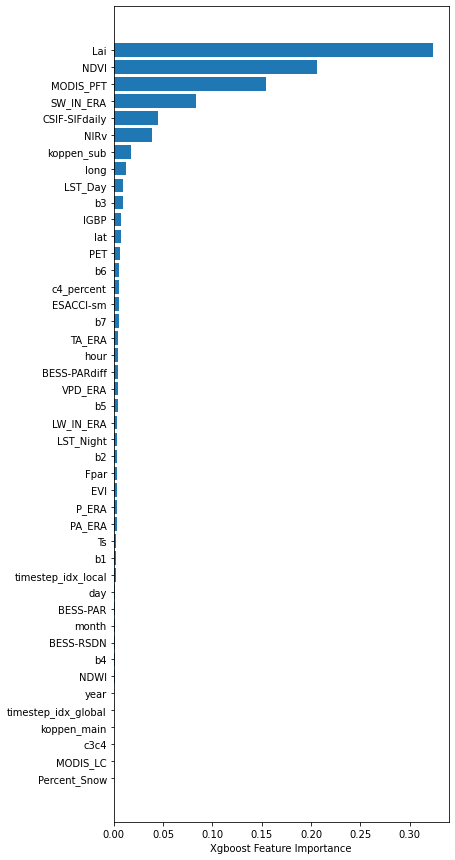

In [ ]:
plt.figure(figsize=(6,15))
sorted_idx = xgb_regressor.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], xgb_regressor.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

In [ ]:
sorted_idxs = xgb_regressor.feature_importances_.argsort()
for sorted_idx in sorted_idxs:
  print(f'{X_train.columns[sorted_idx]}: {round(xgb_regressor.feature_importances_[sorted_idx],4)}')

Percent_Snow: 0.0
MODIS_LC: 0.0
c3c4: 0.0
koppen_main: 0.0
timestep_idx_global: 0.0
year: 0.0
NDWI: 0.0010999999940395355
b4: 0.00139999995008111
BESS-RSDN: 0.001500000013038516
month: 0.001500000013038516
BESS-PAR: 0.0015999999595806003
day: 0.0015999999595806003
timestep_idx_local: 0.002199999988079071
b1: 0.002199999988079071
Ts: 0.0026000000070780516
PA_ERA: 0.00279999990016222
P_ERA: 0.00279999990016222
EVI: 0.00279999990016222
Fpar: 0.003000000026077032
b2: 0.0032999999821186066
LST_Night: 0.0032999999821186066
LW_IN_ERA: 0.0034000000450760126
b5: 0.0038999998942017555
VPD_ERA: 0.004000000189989805
BESS-PARdiff: 0.004399999976158142
hour: 0.004600000102072954
TA_ERA: 0.004699999932199717
b7: 0.004900000058114529
ESACCI-sm: 0.0052999998442828655
c4_percent: 0.00559999980032444
b6: 0.005799999926239252
PET: 0.005799999926239252
lat: 0.006800000090152025
IGBP: 0.007499999832361937
b3: 0.008899999782443047
LST_Day: 0.008899999782443047
long: 0.01269999984651804
koppen_sub: 0.01769999